In [83]:
import os
import json
from msc_project.utils import data_utils as du
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [154]:
DATA_PATH = ["/scratch/msc24h18/msc_project/data/PAUV02"]
READ_VOLTAGES = [0.1, 0.2, 0.3, 0.4, 0.5]

json_files = []
for path in DATA_PATH:
    json_files += du.get_files(path, extension=".json")

all_data = []
for READ_VOLTAGE in READ_VOLTAGES:
    json_data = [json.load(open(file)) for file in json_files]
    data = {"device_id": [], "V_read (pos)": [], "V_read (neg)": [], "I_max (pos)": [], "I_max (neg)": [], "I_min (pos)": [], "I_min (neg)": []}
    for jd in json_data:
        currents, voltages = jd["data"]["sweep_currents"], jd["data"]["sweep_voltages"]
        currents, voltages = np.array(currents), np.array(voltages)

        # do up and down sweeps separately
        voltages_up = voltages[np.where(np.diff(voltages) > 0)]
        voltages_down = voltages[np.where(np.diff(voltages) < 0)]

        currents_up = currents[np.where(np.diff(voltages) > 0)]
        currents_down = currents[np.where(np.diff(voltages) < 0)]
        
        v_read_pos = []
        v_read_neg = []
        i_pos = []
        i_neg = []
        for dir, volt, curr in zip(["up", "down"], [voltages_up, voltages_down], [currents_up, currents_down]):
            idx_pos = np.argmin(np.abs(volt - READ_VOLTAGE))
            idx_neg = np.argmin(np.abs(volt + READ_VOLTAGE))

            v_read_pos.append(volt[idx_pos])
            v_read_neg.append(volt[idx_neg])

            i_pos.append(curr[idx_pos])
            i_neg.append(curr[idx_neg])

        data["device_id"].append(jd["device_id"])
        data["V_read (pos)"].append(np.array(v_read_pos).mean())
        data["V_read (neg)"].append(np.array(v_read_neg).mean())
        data["I_max (pos)"].append(np.array(i_pos).max())
        data["I_max (neg)"].append(np.array(i_neg).max())
        data["I_min (pos)"].append(np.array(i_pos).min())
        data["I_min (neg)"].append(np.array(i_neg).min())

    df = pd.DataFrame(data)
    df = df.groupby("device_id").mean()

    # delete devices not part of the column
    df.drop(1528, inplace=True)
    df.drop(1560, inplace=True)

    all_data.append(df)


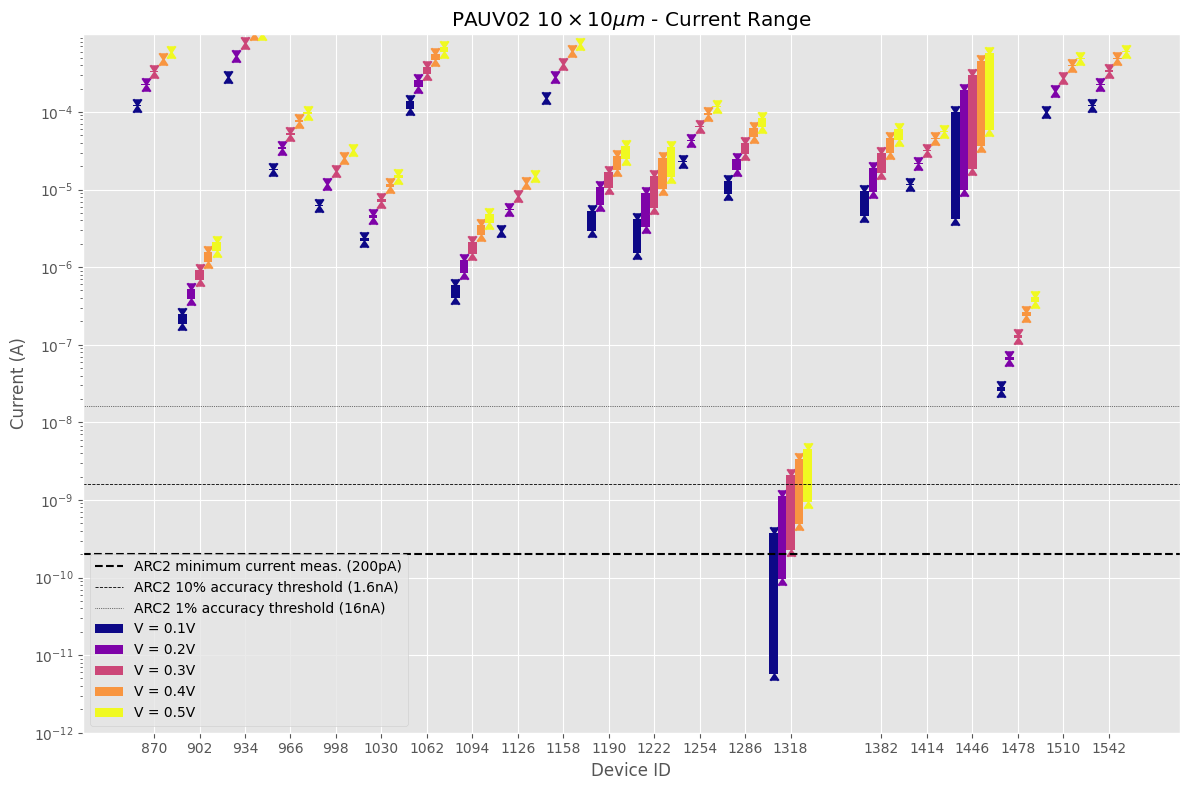

In [164]:
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.plasma(np.linspace(0, 1, len(READ_VOLTAGES)))
separation = 30
width = separation / len(READ_VOLTAGES)
offsets = np.linspace((-separation+width)/2, (separation-width)/2, len(READ_VOLTAGES))
for j, df in enumerate(all_data):
    for i, (device_id, row) in enumerate(df.iterrows()):
        ax.scatter(device_id+offsets[j], row["I_max (pos)"], color=colors[j], marker=7)
        ax.scatter(device_id+offsets[j], row["I_min (pos)"], color=colors[j], marker=6)
        current_range = row["I_max (pos)"] - row["I_min (pos)"]
        ax.bar(device_id+offsets[j], height=current_range, bottom=row["I_min (pos)"], width=width, color=colors[j], label=f'V = {READ_VOLTAGES[j]}V')


ax.set(xlabel='Device ID', ylabel='Current (A)', title=f'PAUV02 $10\\times10\mu m$ - Current Range', yscale='log')
ax.set_xticks(df.index)
ax.set_ylim(1e-12)
ax.axhline(y=200e-12, label='ARC2 minimum current meas. (200pA)', color='black', ls='--')
ax.axhline(y=1.6e-9, label='ARC2 10% accuracy threshold (1.6nA)', color='black', ls='--', lw=0.6)
ax.axhline(y=16e-9, label='ARC2 1% accuracy threshold (16nA)', color='black', ls=':', lw=0.5)

handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys())

plt.tight_layout()
plt.savefig("/scratch/msc24h18/msc_project/results/pauv02/PAUV02_current_range_10x10.png")
plt.show()